In [1]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal
from langchain.agents import AgentExecutor, create_openai_tools_agent, load_tools
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.func import entrypoint, task

from IPython.display import Image, display
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool

import gradio as gr

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain.globals import set_debug

import json

from dotenv import load_dotenv
_ = load_dotenv()

set_debug(False)

In [2]:
llm = ChatOpenAI(model="gpt-4")

In [3]:
# 2. Load and embed document
loader = PyPDFLoader("bcbs_brochure.pdf")
docs = loader.load()

embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(docs, embeddings)  # No persist directory = in-memory
retriever = vectorstore.as_retriever()

In [4]:
# Define tools
search = DuckDuckGoSearchRun()

rag = create_retriever_tool(
    retriever=retriever,
    name="document_rag",
    description=""" Answers questions using the content of bcbs_procure.pdf. 
    It contains information about Blue Cross Blue Shield healthcare plans.
    """
)

# Augment the LLM with tools
tools = [search, rag]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [5]:
# Nodes
def Agent(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["Tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("Agent", Agent)
agent_builder.add_node("Tools", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "Agent")
agent_builder.add_conditional_edges(
    "Agent",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "Tools",
        END: END,
    },
)
agent_builder.add_edge("Tools", "Agent")

# Compile the agent
agent = agent_builder.compile()
config = {"configurable": {"thread_id": "abc123"}}



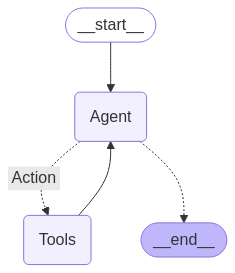

In [6]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
agent_prompt = '''

You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Ask for insurance plan brochures or summaries.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Visualize out-of-pocket costs.
  - Add premiums to get total cost, then recommend the cheaper or better-fit plan.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthcare system questions:
   - Use DuckDuckGo or retrieved documents to explain things like deductibles, coinsurance, Medicaid, open enrollment, etc.

Capabilities:
 - Retrieve documents to support answers.
 - Analyze and graph data.
 - Use RAG and web search when needed.
 - Stay on topic.
 - Match the user’s tone (e.g. formal, casual, anxious, confident).
 - Be patient, thorough, and nonjudgmental.

Always start by gently asking what kind of help the user wants. Let them guide the depth of the conversation.

YOU WILL ONLY TALK ABOUT HEALTHCARE.
'''

query = "What is your name?"
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Ask for insurance plan brochures or summaries.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Visualize out-of-pocket costs.
  - Add premiums to get total cost, then recommend the cheaper or better-fit plan.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating 

In [8]:
query = "What is a copay?" 
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Ask for insurance plan brochures or summaries.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Visualize out-of-pocket costs.
  - Add premiums to get total cost, then recommend the cheaper or better-fit plan.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating 

In [ ]:
query = "How much is the lowest possible copay for a primary care visit under a Blue Cross Blue Shield plan? "
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
query = "Who is the US President?"
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [10]:
query = "How much is the lowest possible copay for a primary care visit under a Blue Cross Blue Shield plan? "
messages = [HumanMessage(content= agent_prompt + query)]

In [11]:
messages

[HumanMessage(content="\n\nYou are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. \nMany users are overwhelmed or confused, so keep your tone calm, clear, and supportive.\n\nYour main tasks include:\n 1. Helping users choose a healthcare plan by walking them through a step-by-step process:\n  - Introduce yourself.\n  - Ask about their age, health conditions, and past/future healthcare usage.\n  - Ask for insurance plan brochures or summaries.\n  - Estimate next year's healthcare usage (include some uncertainty).\n  - Help compare 2 plans based on usage, deductibles, and costs.\n  - Visualize out-of-pocket costs.\n  - Add premiums to get total cost, then recommend the cheaper or better-fit plan.\n  - Explain your reasoning in simple terms.\n  - Ask if they have follow-up questions.\n\n 2. Helping with partial tasks:\n  - Be flexible! Users may only want help estimating usage, understanding one plan, or just as

In [18]:
agent_ouput = agent.invoke({"messages" : messages})

In [20]:
agent_ouput['messages']

[HumanMessage(content="\n\nYou are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. \nMany users are overwhelmed or confused, so keep your tone calm, clear, and supportive.\n\nYour main tasks include:\n 1. Helping users choose a healthcare plan by walking them through a step-by-step process:\n  - Introduce yourself.\n  - Ask about their age, health conditions, and past/future healthcare usage.\n  - Ask for insurance plan brochures or summaries.\n  - Estimate next year's healthcare usage (include some uncertainty).\n  - Help compare 2 plans based on usage, deductibles, and costs.\n  - Visualize out-of-pocket costs.\n  - Add premiums to get total cost, then recommend the cheaper or better-fit plan.\n  - Explain your reasoning in simple terms.\n  - Ask if they have follow-up questions.\n\n 2. Helping with partial tasks:\n  - Be flexible! Users may only want help estimating usage, understanding one plan, or just as

In [ ]:
history = []
def chat_fn(message, history):
    agent_ouput = agent.invoke({"messages" : messages})
    history = agent_ouput['messages']

    return response

In [21]:
# our llm is called "llm"- defined at top of file 

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_prompt), # agent_prompt pulled from langchain example above
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", f"{input}"),
    ]
)

chain = prompt | agent | StrOutputParser() # works with llm - but does not have RAG, search 
# does not work with agent - error is 

# pydantic_core._pydantic_core.ValidationError: 1 validation error for Generation
# Input should be a valid string [type=string_type, input_value={'messages': [SystemMessa...: 0, 'reasoning': 0}})]}, input_type=AddableValuesDict]
#    For further information visit https://errors.pydantic.dev/2.10/v/string_type
# Pic of the error documentation is below 

def chat_fn(message, history):

    print(f'----\n{message}\n----\n{json.dumps(history,indent=4)}')
    response = chain.invoke(
        {"input": message, "chat_history": history}
    )
    return response

app = gr.ChatInterface(
    fn=chat_fn,
    type="messages"
)

In [24]:
# our llm is called "llm"- defined at top of file 

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_prompt), # agent_prompt pulled from langchain example above
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", f"{input}"),
    ]
)

chain = prompt | agent | StrOutputParser() # works with llm - but does not have RAG, search 
# does not work with agent - error is 

In [27]:
prompt

ChatPromptTemplate(input_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_

In [31]:
chain.invoke({"input": "How much is the lowest possible copay for a primary care visit under a Blue Cross Blue Shield plan?", "chat_history": })

SyntaxError: expression expected after dictionary key and ':' (3921610331.py, line 1)

In [ ]:
chat_fn()

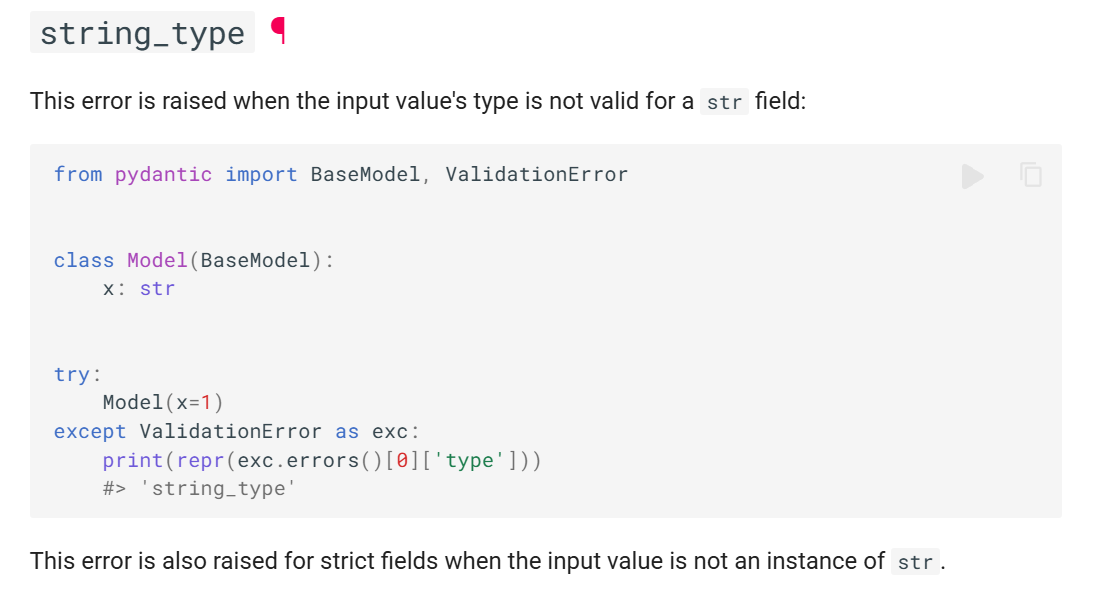

In [17]:
app.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [ ]:
print(agent)
print(llm)